# Titanic passengers survival analysis Kaggle competition

In this notebook we will conduct data analysis and predictive modelling of Titanic passengers survival dataset for Kaggle [Titanic dataset](https://www.kaggle.com/c/titanic).

Titanic passengers survival dataset is one of the most canonical data analysis and machine learning datasets. Let's see how this data looks like, investigate main trends in it and try to predict survival chances of passengers based on numerous data attributes.

The main steps of the analysis process we will conduct are:
1. [Framing the problem](#framing)
2. [Data wrangling](#wrangling)
3. [Data exploration](#exploring)
4. [Modelling data preparation](#preparation)
5. [Models prototyping](#prototyping)
6. [Models hyperparameters fine-tuning](#tuning)
7. [Model test dataset evaluation and deployment](#evaluation)
8. [Summary](#summary)

In [8]:
import numpy as np

from scipy import stats
from statsmodels.formula.api import ols

import pandas as pd
from pandas.tools.plotting import scatter_matrix

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pywaffle import Waffle # pip install pywaffle
%matplotlib inline 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

## 1. Framing the problem <a class="anchor" id="framing"></a>

Titanic sinking was one of the biggest shipwreck tragedies in history. It killed 1502 out of 2224 passengers. This tragedy led to better safety regulations for ships. The main reason for such a great death toll was not enough number of lifeboats to fit all passengers. This can lead to the conclusion that some groups of people were more likely to survive than others - woman, children and upper-class passeners for example.

### 1.1 The goal

The goal of this analysis is two fold. Firstly, we want to analyse the data set, explore it answering related questions using data visualization and statistical methods. Secondly our goal is to predict, by building machine learning model, which passengers were likely to survive Titanic disaster and which not.

### 1.2 Analysis

There are some questions we would like to answer with Titanic dataset analysis.

* What is Titanic passengers demographic structure analyzed in terms of attributes?

* What is the overall Titanic passengers survival ratio?

* What is the survival ratio for different demographic passengers groups? Which groups have biggest chances for survival and which smallest? Is the difference between survived group statistically significant?

### 1.3 Modeling

As for second goal, since we are given multiple attributes with labeled survival target values this is clearly an supervised learning problem. Moreover, we try to predict discrete categorical value: 0 or 1 (representing not-survived and survived passenger). This tells us that we deal here with binary categorization problem.

For each `PassengerId` in the provided unlabeled test set, we want to predict a whether given passenger survived or not.

As a measure of created machine learning models performance we choose the percentage of passengers we correctly predict, that is accuracy level.

As a prediction final product we will prepare and submit to Kaggle a csv file with predicted survival for exactly 418 entries in the test dataset. The file should have exactly 2 columns:
* PassengerId (sorted in any order)
* Survived (contains your binary predictions: 1 for survived, 0 for deceased)

The example submission dataset should look like this:
```
PassengerId,Survived
 892,0
 893,1
 894,0
 Etc.
```

## 2. Data wrangling <a class="anchor" id="wrangling"></a>

Let's get through the process of acquiring the dataset.

### 2.1 Download and load the data.

We download the dataset from Kaggle website. We will first list all files we downloaded.

In [2]:
!ls datasets/

data_description.txt  submission.csv        train.csv
gender_submission.csv test.csv


Now let's start by looking at the data description from Kaggle.

In [3]:
!cat datasets/data_description.txt

Data Dictionary:
survival	Survival		0 = No, 1 = Yes
pclass		Ticket class		1 = 1st, 2 = 2nd, 3 = 3rd
sex		Sex	
Age             Age in years	
sibsp		# of siblings / spouses aboard the Titanic	
parch		# of parents / children aboard the Titanic	
ticket		Ticket number	
fare		Passenger fare	
cabin		Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton


Variable Notes:
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

We see all the details we need to understand data notation here.

We also know that the data has been already split for us into two groups:
* training set (train.csv) - used in data analysis and machine learning model training
* test set (test.csv) - used for machine learning final model testing

That is why we do not have to prepare test dataset in this analysis. 

We are now ready to load and look at our dataset.

In [4]:
titanic_train = pd.read_csv("datasets/train.csv")

### 2.2 Take a quick look at the data

Let's see how our data looks like.

In [5]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Assuming that `PassengerId` attribute values are unique (and they are) let's first make `PassengerId` our index column.

In [6]:
titanic_train = titanic_train.set_index("PassengerId")
titanic_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


As we can see the dataset contains not that many attributes: we have 11 of them. Six of them are numeric: `Survived` (informing whether passenger survived or not), `Pclass` (passenger class), `Age`, `SibSp` (number of siblings/spouses aboard), `Parch` (number of parents/children aboard), `Fare`. Out of these six `Survived` and `Pclass` attributes are numerically encoded categorical values meaning that calculating descriptive statistics for them is meaningless.

Five attributes are categorical textual values: `Name`, `Sex`, `Ticket`, `Cabin`, `Embarked` (port of embarkation C=Cherbourg, Q=Queenstown, S=Southampton). 

Our dataset target attribute is `Survived` marking whether passenger survived or not with 1 or 0 respectively.

Let's have a closer look at attributes structure.

In [7]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


All in all the dataset contains 891 passengers data out of all 2224 passengers.

We deal here with some missing values. The most missing values are in `Cabin` attribute. That column seems not so much informative and the data is rather scarse which is suggesting droping this attribute when preparing training dataset for machine learning. We have also a lot of missing values in `Age` column, however this column seems crucial for our analysis. That is why later on we will have to take care of these missing values either by filling them in (e.g. median value) or by dropping examples with missing values. In `Embarked` attribute values we miss only two values so we can easily drop these two cases later on when preparing the dataset for modelling algorithms.

We again see that five attributes have categorical/text values - we will also deal with that later when preparing data for modelling.

Let's now see some details about numerical values we have in the dataset.

In [8]:
titanic_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The only attributes for which calculating statistical values make sense are `Age`, `SibSp`, `Parch` and `Fare`  attributes. We will analyse demographical passengers structure a bit later. All in all the values look correct and it seems data needs no more corrections at this stage of the analysis.

We can also see here that attributes values ranges are very different. We will have to be standardized later on when preparing data for modeling.

We are ready to move to the data exploration phase.

## 3. Data exploration <a class="anchor" id="exploring"></a>

Let's now dig deeper into data internal structure and values.

## 3.1 Attributes analysis

Let's first look at the general numeric data distributions including the target value `Survived` attribute.

In [9]:
titanic_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118c0d898>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x118d0e3c8>]], dtype=object)

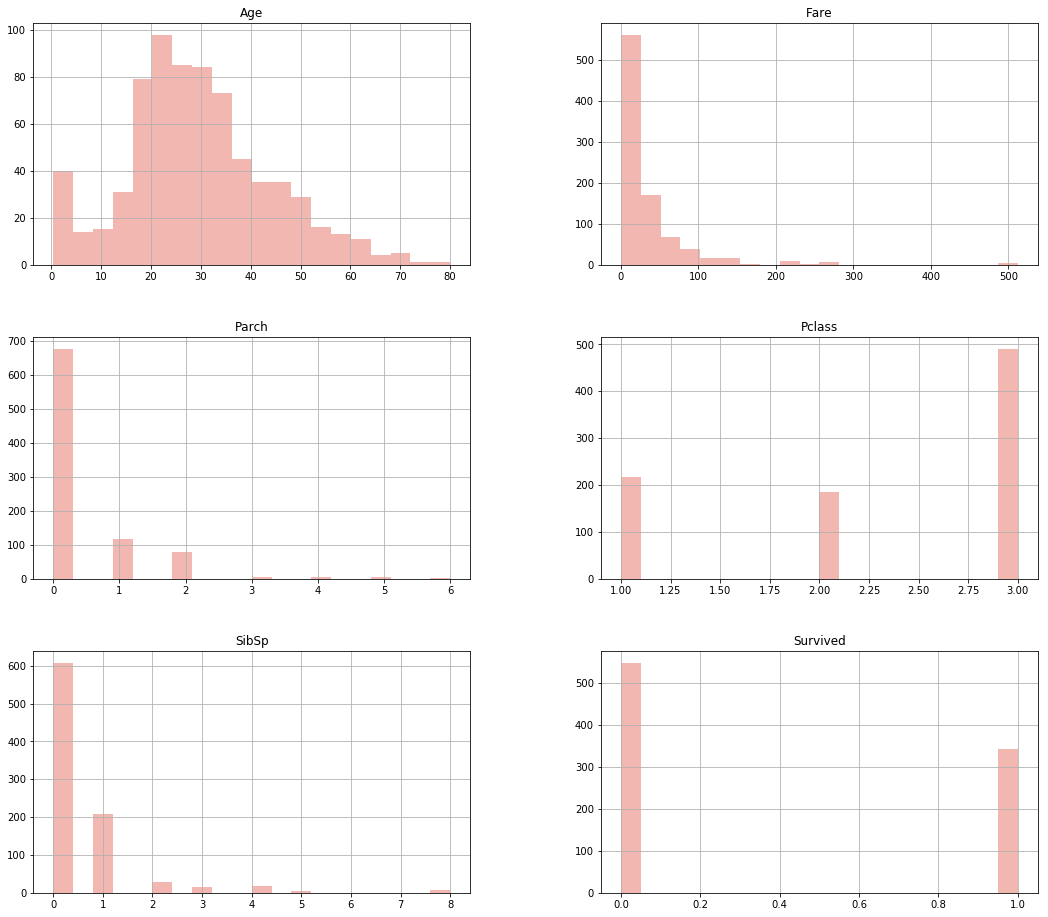

In [10]:
titanic_train.hist(bins=20, figsize=(18, 16), color="#f1b7b0")

We notice a few things in these histograms: 
- `Age` distribution is centered around 20-30 years ranging to 80 with quite large number of children aged 0-5. The minimal age value is 0.42 and the maximal is 80. The mean value is 29.6991 with quite large standard deviation of 14.5264. The median value is 28.
- `Fare` attribute values distribution is strongly positevely skewed with mean 32.2042 and large stadard deviation of 49.6934. Because the distribution is skewed median is much smaller than the mean with value of 14.4542. The range of data is large ranging from 0 to 512. At the same time 75% of the data is lower than 31. 
- `Parch` (the number of parents/children aboard) distribution mode is 0 by far meaning that most of the passengers traveled without any parents/children and also there are some outlier values with 3 and more parents/children aboard.
- `Pclass` distribution shows that almost 500 out of all 891 passengers in the dataset were travelling the 3rd (lowest) class and almost 200 passengers were travelling both in 1st and 2nd class.
- `SibSp` (number of siblings/spouses aboard) is similar to `Parch` distribution but with larger number of passengers travelling with one sibling/spouse.
- `Survived` obviously shows only two values but we can also see that number of survivors is much smaller than the number of passengers who died in the disaster.

Let's also look at catgorical attributes values: `Name`, `Sex`, `Ticket`, `Cabin`, `Embarked`.

In [11]:
titanic_train["Name"].value_counts()

Wiseman, Mr. Phillippe                                   1
Yousif, Mr. Wazli                                        1
Connors, Mr. Patrick                                     1
Bishop, Mr. Dickinson H                                  1
Jensen, Mr. Hans Peder                                   1
Kelly, Mrs. Florence "Fannie"                            1
Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)            1
LeRoy, Miss. Bertha                                      1
Lester, Mr. James                                        1
Lindblom, Miss. Augusta Charlotta                        1
Doharr, Mr. Tannous                                      1
Webber, Miss. Susan                                      1
Flynn, Mr. John                                          1
Davies, Mr. Charles Henry                                1
Turja, Miss. Anna Sofia                                  1
Ivanoff, Mr. Kanio                                       1
Lam, Mr. Len                                            

`Names`, by definition, are rather unique so its distribution would be uniform. It is not categorical attribute then - just textual. This tells us that in modelling phase this value will not be of too much help since there are no group of values that model can identify.

In [12]:
titanic_train["Ticket"].value_counts()

CA. 2343             7
1601                 7
347082               7
347088               6
3101295              6
CA 2144              6
S.O.C. 14879         5
382652               5
LINE                 4
4133                 4
2666                 4
W./C. 6608           4
PC 17757             4
113781               4
17421                4
349909               4
347077               4
19950                4
113760               4
35273                3
PC 17572             3
C.A. 31921           3
PC 17582             3
F.C.C. 13529         3
24160                3
345773               3
371110               3
347742               3
248727               3
SC/Paris 2123        3
                    ..
695                  1
29103                1
STON/O2. 3101282     1
2650                 1
C.A. 24580           1
19988                1
STON/O 2. 3101288    1
113056               1
2686                 1
237798               1
330958               1
STON/O2. 3101271     1
368703     

`Ticket` attribute is also not a classical categorical attribute with multiple unique or close to unique values. There some values repetition but rather tickets identifiers (as we assume they are) are unique. This again can lead to the conclusion that this attribute will not be helpful in survival prediction.

In [13]:
titanic_train["Cabin"].value_counts()

G6             4
C23 C25 C27    4
B96 B98        4
E101           3
F33            3
C22 C26        3
F2             3
D              3
C83            2
C126           2
C68            2
D20            2
B18            2
D33            2
C65            2
D26            2
B28            2
C125           2
C92            2
B58 B60        2
E121           2
B22            2
E8             2
E25            2
D35            2
B5             2
E24            2
E67            2
D17            2
E44            2
              ..
C47            1
B38            1
D6             1
C111           1
B80            1
B41            1
E58            1
C95            1
C49            1
D19            1
B86            1
B101           1
D28            1
D9             1
C110           1
D47            1
A32            1
B42            1
F E69          1
A5             1
D15            1
B69            1
B73            1
E38            1
A16            1
D50            1
D7             1
C30           

`Cabin` is similar in structure to the `Name` and `Ticket` attributes. It is again rather textual attribute and not categorical. As we saw earlier this is the attribute with the biggest number of missing values: we have only 204 values out of all 891 passengers and the rest is missing. All this suggest that also this attribute will not be of much help during the modeling phase of this project.

In [14]:
titanic_train["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

`Sex` attribute has only two possible values: `male` and `female`. It is a categorical attribute. Let's plot it.

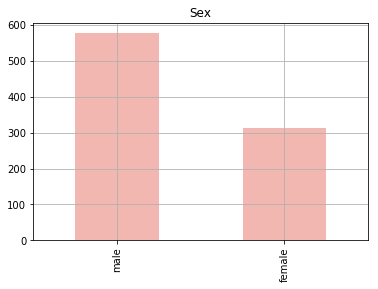

In [15]:
titanic_train["Sex"].value_counts().plot(kind='bar', figsize=(6, 4), grid=True, color="#f1b7b0", title="Sex")

We see that on Titanic (as measured by analysed dataset) there were almost twice as much males as females.

In [16]:
titanic_train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

`Embarked` attribute has three possible values: `S`, `C` and `Q` (standing for Southampton, Cherbourg or Queenstown city of embarkation) meaning that it is categorical attribute. Let's plot it's values.

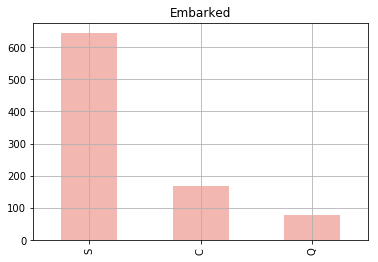

In [17]:
titanic_train["Embarked"].value_counts().plot(kind='bar', figsize=(6, 4), grid=True, color="#f1b7b0", title="Embarked")

We can see that vast majority of passengers embarked in Southampton port, less than 200 passengers embarked in Cherbourg and less then 100 embarked in Queenstown. For now we can tell nothing more out of it but later on we will try to see how this attribute values affected the survival chances of passengers.

It looks like we have 7 attributes that we can explore for how their values affect pasengers survival chances. These are the five numerical attributes: `Pclass` (passenger class), `Age` (passenger age), `SibSp` (number of siblings/spouses aboard), `Parch` (number of parents/children aboard), `Fare` (fare passenger paid). There are also two categorical attributes that looks like factors that can be analysed for influencing passengers survival chances: `Sex` (passenger sex) and `Embarked` (port of embarkation). 

In further analysis and modelling we will concentrate on these attributes when analysing and modeling passengers survival. `Name`, `Ticket` and `Cabin` attributes are textual non-categorical and rather unique values and as such are hard to analyze in terms of finding some patterns or relations between them and survival chances.

As a sidenote `Sex` and `Embarked` attributes, as categorical values, can be numerically encoded. We will perform this when preparing the data for modeling stage.

We can finish now studying individual attributes properties and start looking at relations between them.

## 3.2 Relations between attributes analysis

Let's now dig deeper into data internal relations. Since our dataset is not very large we can create scatter plot between each of the numerical attributes.

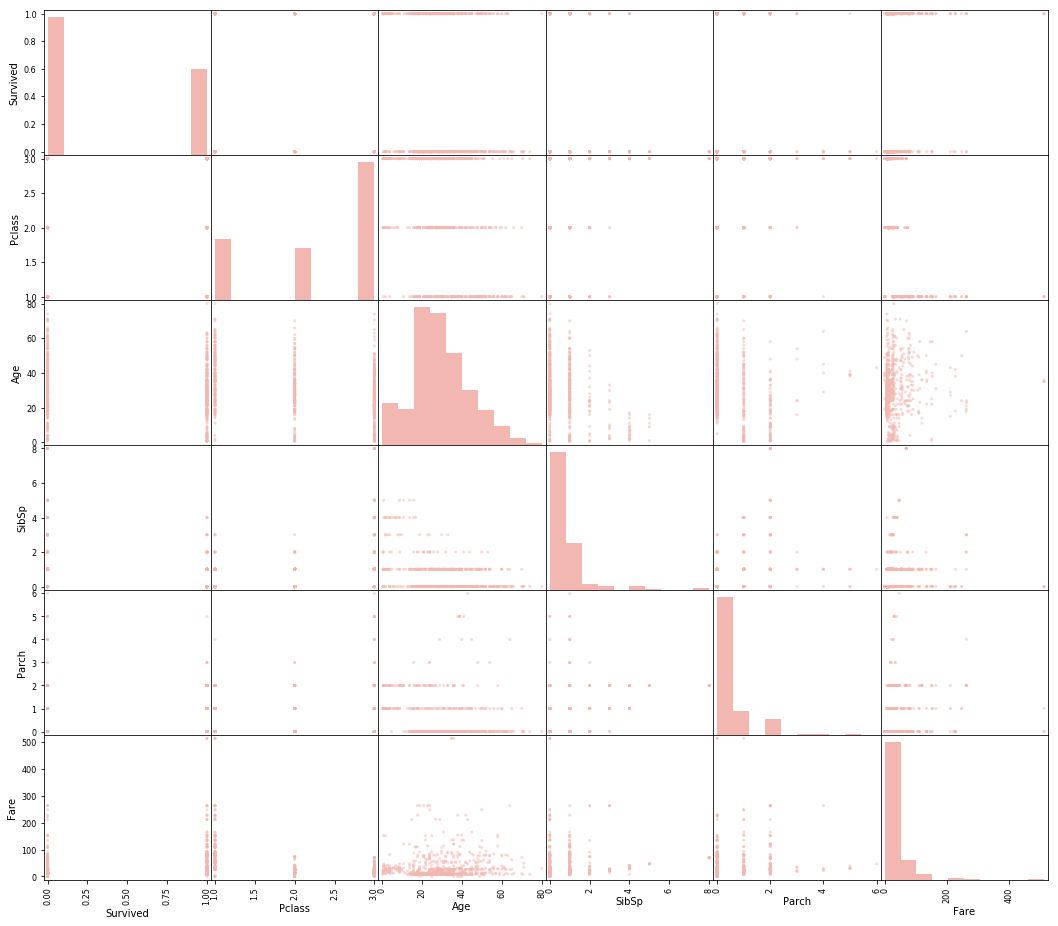

In [18]:
scatter_matrix(titanic_train, figsize=(18, 16), c="#f1b7b0", hist_kwds={'color':['#f1b7b0']});

It is quite difficult to read something informative from scatter plots since some of the data is not continous.

Let's then compute the correlation matrix showing correlation coefficient between each numerical attribute.

In [19]:
corr_matrix = titanic_train.corr()
corr_matrix

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


We can see some meaningful correlations here. To get even better intuition let's visualize the correlation matrix.

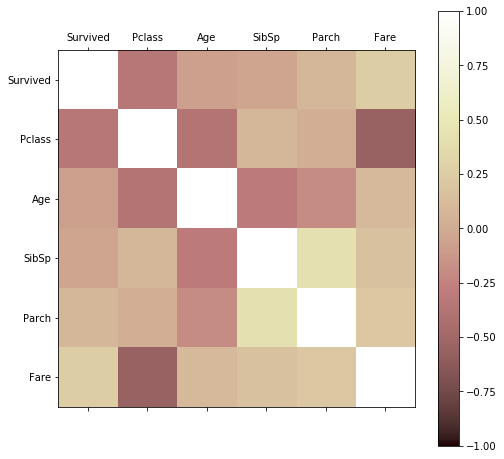

In [20]:
fig, axes = plt.subplots(figsize=(8, 8))
cax = axes.matshow(corr_matrix, vmin=-1, vmax=1, cmap=plt.cm.pink)
fig.colorbar(cax)
ticks = np.arange(0, len(corr_matrix), 1)
axes.set_xticks(ticks)
axes.set_yticks(ticks)
axes.set_xticklabels(corr_matrix)
axes.set_yticklabels(corr_matrix)
plt.show()

Analyzing correlation let's remember that our target value is `Survived` attribute. 

Let's concentrate for now on correlation between target value and other attributes. We see quite strong positive correlation between `Fare` and `Survived` attributes values (0.2573) meaning that who payed more for the ticked could have for some reason higher chances for survival. There is also quite strong negative correlation between `Pclass` and `Survived` attributes values (-0.3385) similarly meaning that the higher class passenger was travelling the lower was risk for not surviving. The rest of the attributes seems not correlated strongly with `Survived`. 

Looking at relations between other attributes an obvious intution is strong negative correlation between `Pclass` and `Fare` (-0.5495): the more expensive ticket usually means better standard and lower class number (1st class is the most luxourious).

Other interesting insight is quite strong positive correlation between `SibSp` and `Parch` attributes (0.41)meaning that someone who travels with siblings or spouse tends to also travel with parents or children.

Surprising is positive correlation between `Parch` and `Fare` attributes (0.2162) meaning that person traveling with parents or children tends to pay more for the ticket. Similar but with lower correlation in case of `SibSp` attribute.

Other more distinct relation we can see in the dataset is negative correlation between `Pclass` and `Age` (-0.3692). We can interpret it as the lower class number (and high standard) the higher age which seems reasonable.

Also interesting is the high negative correlation between `Age` and `SibSp` (-0.3083). It conveys interesting fact that the older passenger was the lower was the number of siblings travelling with.

We now have quite deep insight in what is going on in the dataset. We will now proceed to answering question posed at the begining of this analysis.

## 3.3 What was Titanic passengers demographic structure analyzed in terms of attributes?

In this part we will analyze attributes we found meaningful in terms of survival analysis: `Pclass`, `Sex`, `Age`, `SibSp`, `Parch`, `Fare` and `Embarked`. We will not analyze `Name`, `Ticket` and `Cabin` attributes since we found that they do not convey information in terms of population survival analysis.

Let's start with ticket class analysis - how many passengers travelled in each of the ticket classes. On Titanic there were three tickets classes: first, second and third. They are represented in the dataset using values 1, 2 and 3.  

In [21]:
titanic_class_counts = titanic_train["Pclass"].value_counts(sort=False)
titanic_class_counts.index = ["First class", "Second class", "Third class"]
titanic_class_counts

First class     216
Second class    184
Third class     491
Name: Pclass, dtype: int64

Let's see how does this population of passengers looks like.

In [22]:
def get_waffle_plot(data, rows, title):
    colors=("#f1b7b0", "#f0f0f0", "#cccccc", "#e3d8c0", "#f9d9ac", "#fdf1b6", "#f7dceb")
    fig = plt.figure(
        FigureClass=Waffle, 
        rows=rows,
        values=data, 
        colors=colors[:len(data)],
        title={'label': title, 'loc': 'left', "fontsize": 14},
        figsize=(20, 4),
        labels=["{} ({}, {:.2f}%)".format(k, v, v / sum(data.values()) * 100) for k, v in data.items()],
        legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.3), 'ncol': len(data), 'framealpha': 0, "fontsize": 14, "handlelength": 0.7}
)

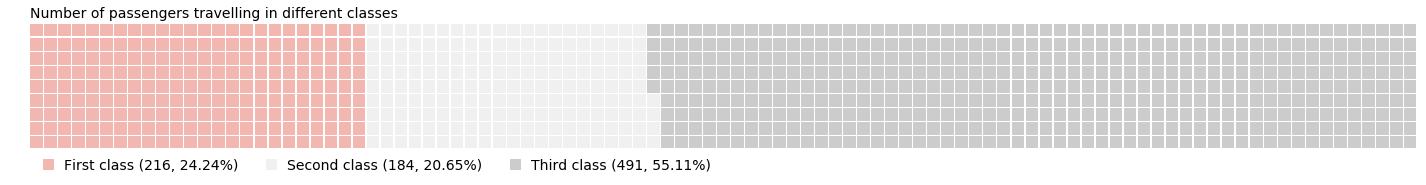

In [23]:
get_waffle_plot(titanic_class_counts.to_dict(), rows=9, title="Number of passengers travelling in different classes")

We see that vast majority (55.11%) of passengers travelled in lowest third class and almost 25% of passengers travelled in first class. 

In [24]:
titanic_sex_counts = titanic_train["Sex"].value_counts()
titanic_sex_counts

male      577
female    314
Name: Sex, dtype: int64

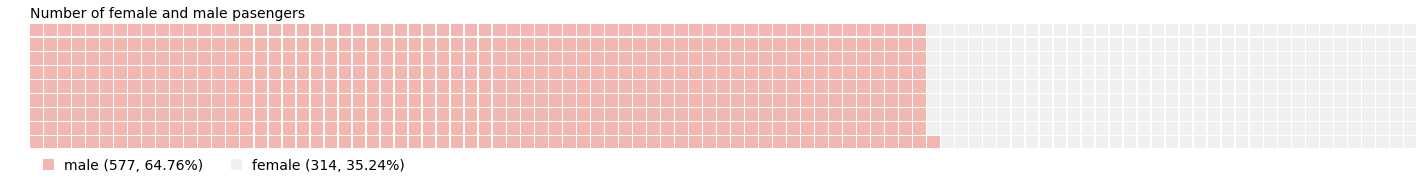

In [25]:
get_waffle_plot(titanic_sex_counts.to_dict(), rows=9, title="Number of female and male pasengers")

Majority of all passengers were males (64.76%) with only 35.24% of females.

To analyze age we need first to bin the data into meaningful age groups.

In [26]:
titanic_age_groups_counts = pd.cut(titanic_train["Age"], bins=[0, 14, 24, 34, 44, 54, 64, 80]).value_counts().sort_index()
titanic_age_groups_counts

(0, 14]      77
(14, 24]    200
(24, 34]    201
(34, 44]    121
(44, 54]     73
(54, 64]     31
(64, 80]     11
Name: Age, dtype: int64

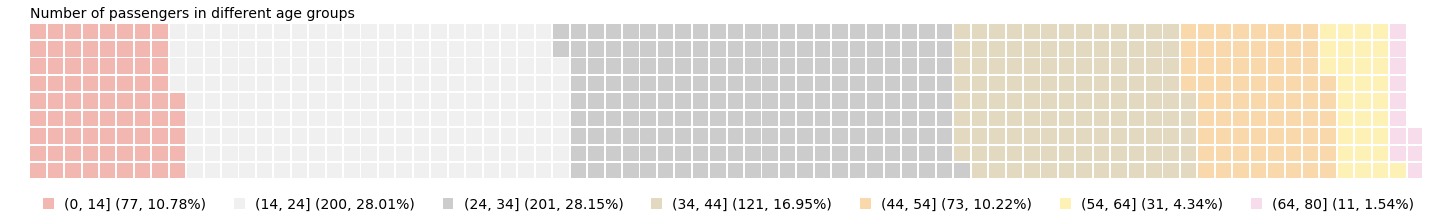

In [27]:
get_waffle_plot(titanic_age_groups_counts.to_dict(), rows=9, title="Number of passengers in different age groups")

10.78% of passengers were children in age 0-14. A little over 28% of passengers were both between 14-24 and 24-34 years old. Almost 17% of all passengers were 34-44 years old. Only 16% of all passengers were above 44 years old. That tells us that Titanic passengers population was quite young.

Just out of interest let's dig a bit deeper into passengers age distribution properties.

In [28]:
titanic_train["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

We can see that the youngest passenger was 5 months old (0.42 year old). Let's see who she or he was.

In [29]:
titanic_train.loc[titanic_train["Age"].argmin()]

Survived                                  1
Pclass                                    3
Name        Thomas, Master. Assad Alexander
Sex                                    male
Age                                    0.42
SibSp                                     0
Parch                                     1
Ticket                                 2625
Fare                                 8.5167
Cabin                                   NaN
Embarked                                  C
Name: 804, dtype: object

It was a boy: Assed Alexander Thomas born in Hardīn, Lebanon on 8 November 1911. He survived Titanic disaster - you can read his story [here](https://www.encyclopedia-titanica.org/titanic-survivor/assad-alexander-thomas-tannous.html).

On the other side of passengers dataset age distribution is the oldest passenger who was 80. Let's see who she or he was.

In [30]:
titanic_train.loc[titanic_train["Age"].argmax()]

Survived                                       1
Pclass                                         1
Name        Barkworth, Mr. Algernon Henry Wilson
Sex                                         male
Age                                           80
SibSp                                          0
Parch                                          0
Ticket                                     27042
Fare                                          30
Cabin                                        A23
Embarked                                       S
Name: 631, dtype: object

By accident we found error in the Titanic dataset. When you read Algernon Henry Wilson Barkworth biography (you can find it [here](https://www.encyclopedia-titanica.org/titanic-survivor/algernon-barkworth.html)), we can read that he was born in 1864. That means that in 1912, when Titanic disaster happened, he was 48 years old and not 80 as stated in the dataset. 

So why 80 in the data set? We can further read that this person died in 1945 - aged 80. This means that dataset contains for this passenger age value of post Titanic death and not day of disaster age as it does for other survived passengers age attribute values. This inconsistency makes the data invalid and confusing when it comes to factual or historical value.

For this reason we decide to discard this passenger data from further analysis or modelling.


In [31]:
titanic_train = titanic_train.drop(titanic_train["Age"].argmax(), axis=0)

In [32]:
titanic_train["Age"].describe()

count    713.000000
mean      29.628569
std       14.413774
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       74.000000
Name: Age, dtype: float64

And now we need to bin passengers ages once again.

In [33]:
titanic_age_groups_counts = pd.cut(titanic_train["Age"], bins=[0, 14, 24, 34, 44, 54, 64, 80]).value_counts().sort_index()
titanic_age_groups_counts

(0, 14]      77
(14, 24]    200
(24, 34]    201
(34, 44]    121
(44, 54]     73
(54, 64]     31
(64, 80]     10
Name: Age, dtype: int64

Let's now check again who is the oldest passenger in the data set - after removing the incorect data record.

In [34]:
titanic_train.loc[titanic_train["Age"].argmax()]

Survived                      0
Pclass                        3
Name        Svensson, Mr. Johan
Sex                        male
Age                          74
SibSp                         0
Parch                         0
Ticket                   347060
Fare                      7.775
Cabin                       NaN
Embarked                      S
Name: 852, dtype: object

So now we have for sure the oldest known Titanic passenger. His name was Johan Svensson, aged 74 and unfortunatelly died in the disaster (read more [here](https://www.encyclopedia-titanica.org/titanic-victim/johan-svensson.html)).

In [35]:
titanic_sibsp_counts = titanic_train["SibSp"].value_counts()
titanic_sibsp_counts

0    607
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

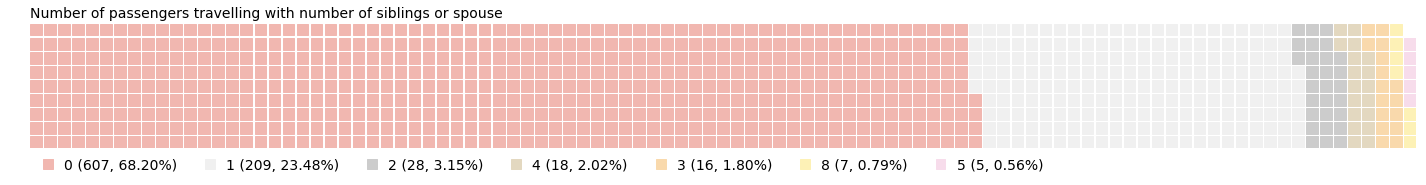

In [36]:
get_waffle_plot(titanic_sibsp_counts.to_dict(), rows=9, title="Number of passengers travelling with number of siblings or spouse")

Let's move with the demographic analysis to next attribute. Vast majority of passengers travelled without any siblings or spouse - 68.24%. 23.46% of passengers travelled with one child or spouse. Less than 9% of all passengers traveled with more than one sibling or spouse.

In [37]:
titanic_parch_counts = titanic_train["Parch"].value_counts()
titanic_parch_counts

0    677
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

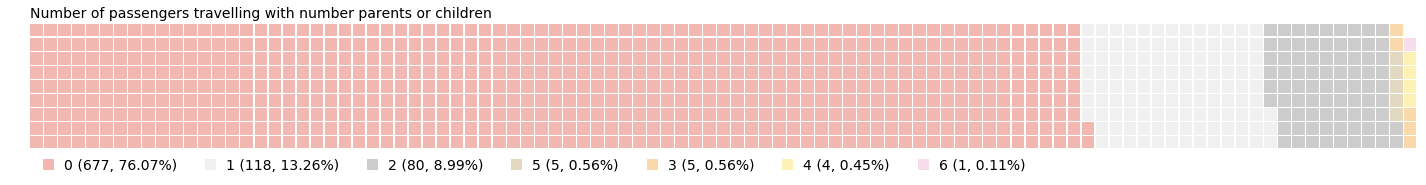

In [38]:
get_waffle_plot(titanic_parch_counts.to_dict(), rows=9, title="Number of passengers travelling with number parents or children")

The situation is very similar in case of passengers travelling with parents or children. Most of them (76.09%) travelled alone and 13.24% travelled with just one parent or children. 8.89% of passengers travelled with two parents or children.

In [39]:
titanic_fare_groups_counts = pd.cut(titanic_train["Fare"], bins=[0, 20, 40, 60, 80, 100, 300, 600]).value_counts().sort_index()
titanic_fare_groups_counts

(0, 20]       500
(20, 40]      199
(40, 60]       54
(60, 80]       48
(80, 100]      21
(100, 300]     50
(300, 600]      3
Name: Fare, dtype: int64

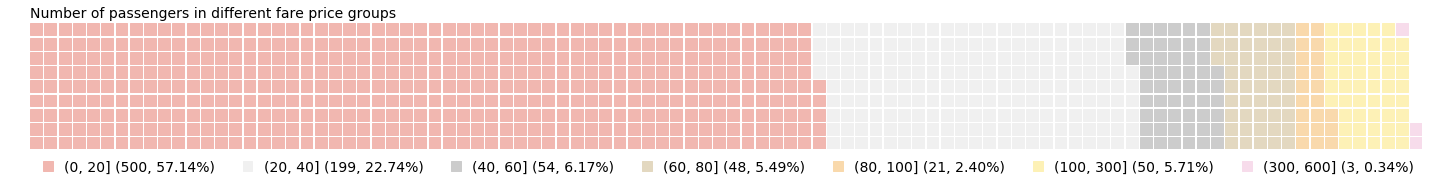

In [40]:
get_waffle_plot(titanic_fare_groups_counts.to_dict(), rows=9, title="Number of passengers in different fare price groups")

In terms ticket fare over the half (57.08%) of passengers paid the lowest fare ranging from 0 to 20. Let's remember that we saw that 55.11% of passengers travelled in third class. That follows the result seen here: third class was the cheapest way to travel and the number of passengers in the third class in almost the same as number of passengers who were in the lowest fare group. Again 22.83% passengers paid between 20 and 40 fare. That approximately corresponds to 20.65% of passengers travelling in the second class. We see that the rest of the ticket prices - which most likely are first class tickets - varies very much probably meaning some additional luxuries and services. And also there is relatively small number of such tickets.


In [41]:
titanic_embarked_counts = titanic_train["Embarked"].value_counts()
titanic_embarked_counts.index = ["Southampton", "Cherbourg", "Queenstown"]
titanic_embarked_counts

Southampton    643
Cherbourg      168
Queenstown      77
Name: Embarked, dtype: int64

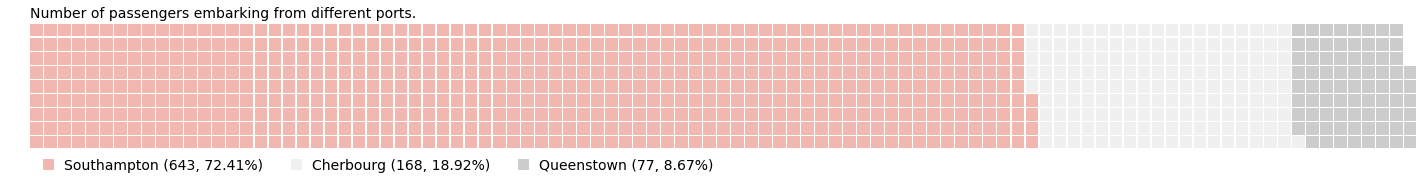

In [42]:
get_waffle_plot(titanic_embarked_counts.to_dict(), rows=9, title="Number of passengers embarking from different ports.")

We can see that vast majority of passengers embarked in Southampton (72.44%), 18.9% embarked in Cherbourg and only 8.66% of passengers embarked Titanic in Queenstown.

## 3.4 What is the overall Titanic passengers survival ratio? 

We will now try to answer what is the overall Titanic passengers survival ratio. To to that we will create survival ratio metric. We will define it as the ratio between the number of survived passengers and the overall number of passengers. We will use this value for later reference and comparison in passengers subgroups survival analysis.

Our dataset contains 891 passengers data out of all 2224 passengers. This is partly due to the reason that we work with labeled train dataset with separate unlabeled test dataset containing 418 passengers data set aside. In this analysis we will treat these 891 passengers not as a sample but rather as our whole population of passengers. The same assumption will apply to subsequent parts of this analysis.

Let's now see what is the total number of survived passengers and and those who did not survive. 

In [43]:
titanic_survived_counts = titanic_train["Survived"].value_counts(sort=False)
titanic_survived_counts.index = ["Not survived", "Survived"]
titanic_survived_counts

Not survived    549
Survived        341
Name: Survived, dtype: int64

Let's visualize it.

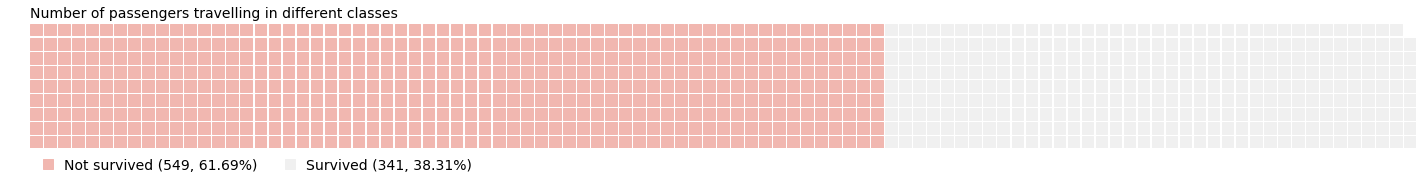

In [44]:
get_waffle_plot(titanic_survived_counts.to_dict(), rows=9, title="Number of passengers travelling in different classes")

Let's also create overall survival ratio metric.

In [45]:
def get_survival_ratio(passengers_df):
    return passengers_df["Survived"].sum() / passengers_df["Survived"].count()

In [46]:
overall_survival_ratio = get_survival_ratio(titanic_train)
overall_survival_ratio

0.38314606741573032

We see that out of Titanic 891 passengers only 342 survived and 549 died. The Titanic survival ratio is approximately 0.3838, meaning that only 38.38% of all passengers (again, we are talking here about population of passengers in the dataset) survived the disaster. That is really small percentage. 

We can see that majority of Titanic passengers died in the disaster. Let's keep these values - especially the overal survival ratio metric among all Titanic passengers of 0.3838 - as a reference point for further analysis.


## 3.5 What is the survival ratio for different demographic passengers groups? Which groups have biggest chances for survival and which smallest?

Let's now finally see how survival ratio changes for passengers belonging to attributes demographic sub-categories. In this analysis we will process the same attributes as in previous parts: `Pclass`, `Sex`, `Age`, `SibSp`, `Parch`, `Fare` and `Embarked`. 

We will start by grouping dataset using each of the attributes unique values besides `Age` and `Fare` attributes which we will group using values ranges. Later, based on these grouped values, we will calculate survival ratio for each of the attributes subgroups.

In [47]:
titanic_pclass_group = titanic_train.groupby("Pclass")
titanic_pclass_group.groups

{1: Int64Index([  2,   4,   7,  12,  24,  28,  31,  32,  35,  36,
             ...
             854, 857, 858, 863, 868, 872, 873, 880, 888, 890],
            dtype='int64', name='PassengerId', length=215),
 2: Int64Index([ 10,  16,  18,  21,  22,  34,  42,  44,  54,  57,
             ...
             849, 855, 862, 865, 866, 867, 875, 881, 884, 887],
            dtype='int64', name='PassengerId', length=184),
 3: Int64Index([  1,   3,   5,   6,   8,   9,  11,  13,  14,  15,
             ...
             876, 877, 878, 879, 882, 883, 885, 886, 889, 891],
            dtype='int64', name='PassengerId', length=491)}

In [48]:
titanic_sex_group = titanic_train.groupby("Sex")
titanic_sex_group.groups

{'female': Int64Index([  2,   3,   4,   9,  10,  11,  12,  15,  16,  19,
             ...
             867, 872, 875, 876, 880, 881, 883, 886, 888, 889],
            dtype='int64', name='PassengerId', length=314),
 'male': Int64Index([  1,   5,   6,   7,   8,  13,  14,  17,  18,  21,
             ...
             874, 877, 878, 879, 882, 884, 885, 887, 890, 891],
            dtype='int64', name='PassengerId', length=576)}

In case of `Age` attribute we will group its values into age groups as we did previously in demographic analysis.

In [49]:
titanic_age_group = titanic_train.groupby(pd.cut(titanic_train["Age"], bins=[0, 14, 24, 34, 44, 54, 64, 80]))
titanic_age_group.groups

{Interval(0, 14, closed='right'): Int64Index([  8,  10,  11,  15,  17,  25,  40,  44,  51,  59,  60,  64,  79,
             120, 126, 148, 165, 166, 172, 173, 183, 184, 185, 194, 206, 234,
             238, 262, 279, 298, 306, 341, 349, 375, 382, 387, 408, 420, 436,
             446, 447, 449, 470, 480, 481, 490, 531, 536, 542, 543, 550, 619,
             635, 643, 645, 684, 687, 692, 721, 732, 751, 752, 756, 778, 781,
             788, 789, 803, 804, 814, 820, 825, 828, 832, 851, 853, 870],
            dtype='int64', name='PassengerId'),
 Interval(14, 24, closed='right'): Int64Index([  1,  13,  23,  28,  38,  39,  45,  50,  52,  57,
             ...
             854, 856, 859, 862, 865, 876, 877, 878, 883, 888],
            dtype='int64', name='PassengerId', length=200),
 Interval(24, 34, closed='right'): Int64Index([  3,   9,  19,  22,  24,  35,  42,  54,  58,  67,
             ...
             871, 873, 875, 881, 882, 884, 885, 887, 890, 891],
            dtype='int64', name='Passen

In [50]:
titanic_sibsp_group = titanic_train.groupby("SibSp")
titanic_sibsp_group.groups

{0: Int64Index([  3,   5,   6,   7,   9,  12,  13,  15,  16,  18,
             ...
             881, 882, 883, 884, 885, 886, 887, 888, 890, 891],
            dtype='int64', name='PassengerId', length=607),
 1: Int64Index([  1,   2,   4,  10,  11,  14,  19,  26,  32,  35,
             ...
             850, 853, 855, 857, 862, 867, 870, 872, 875, 889],
            dtype='int64', name='PassengerId', length=209),
 2: Int64Index([ 39,  49,  70, 105, 121, 148, 184, 246, 302, 312, 331, 334, 393,
             437, 438, 449, 470, 530, 566, 572, 601, 619, 645, 656, 661, 666,
             743, 861],
            dtype='int64', name='PassengerId'),
 3: Int64Index([8, 25, 28, 64, 86, 89, 177, 230, 342, 375, 410, 486, 635, 643, 727,
             820],
            dtype='int64', name='PassengerId'),
 4: Int64Index([ 17,  51,  69, 120, 165, 172, 183, 234, 262, 267, 279, 542, 543,
             687, 788, 814, 825, 851],
            dtype='int64', name='PassengerId'),
 5: Int64Index([60, 72, 387, 481, 68

In [51]:
titanic_parch_group = titanic_train.groupby("Parch")
titanic_parch_group.groups

{0: Int64Index([  1,   2,   3,   4,   5,   6,   7,  10,  12,  13,
             ...
             878, 879, 882, 883, 884, 885, 887, 888, 890, 891],
            dtype='int64', name='PassengerId', length=677),
 1: Int64Index([  8,  11,  17,  25,  51,  55,  66,  98,  99, 103,
             ...
             836, 849, 853, 854, 856, 857, 870, 872, 880, 881],
            dtype='int64', name='PassengerId', length=118),
 2: Int64Index([  9,  28,  44,  59,  60,  64,  69,  72,  79,  89,  94, 120, 137,
             141, 148, 149, 154, 160, 166, 181, 183, 185, 202, 234, 238, 248,
             255, 256, 262, 298, 306, 312, 319, 325, 342, 378, 382, 387, 391,
             395, 418, 420, 436, 437, 446, 451, 473, 481, 499, 507, 534, 536,
             540, 541, 542, 543, 551, 586, 594, 609, 616, 635, 643, 660, 684,
             686, 743, 755, 764, 784, 789, 793, 803, 814, 820, 828, 847, 851,
             864, 889],
            dtype='int64', name='PassengerId'),
 3: Int64Index([87, 438, 737, 775, 859], dt

And also like in demographic analysis we will binnarize the `Fare` attribute values.

In [52]:
titanic_fare_group = titanic_train.groupby(pd.cut(titanic_train["Fare"], bins=[0, 20, 40, 60, 80, 100, 300, 600]))
titanic_fare_group.groups

{Interval(0, 20, closed='right'): Int64Index([  1,   3,   5,   6,   9,  11,  13,  15,  16,  18,
             ...
             876, 877, 878, 879, 882, 883, 884, 885, 887, 891],
            dtype='int64', name='PassengerId', length=500),
 Interval(20, 40, closed='right'): Int64Index([  8,  10,  12,  14,  17,  21,  24,  25,  26,  31,
             ...
             854, 855, 858, 863, 875, 881, 886, 888, 889, 890],
            dtype='int64', name='PassengerId', length=199),
 Interval(40, 60, closed='right'): Int64Index([  4,   7,  36,  44,  60,  72,  75,  84, 111, 138, 167, 170, 186,
             249, 310, 330, 357, 371, 384, 387, 435, 458, 476, 481, 494, 510,
             514, 524, 540, 572, 578, 584, 600, 603, 609, 622, 644, 670, 672,
             679, 684, 686, 691, 693, 711, 713, 725, 749, 782, 810, 827, 839,
             868, 872],
            dtype='int64', name='PassengerId'),
 Interval(60, 80, closed='right'): Int64Index([  2,  53,  55,  62,  73,  93,  98, 103, 121, 125, 140, 152, 

In [53]:
titanic_embarked_group = titanic_train.groupby("Embarked")
titanic_embarked_group.groups

{'C': Int64Index([  2,  10,  20,  27,  31,  32,  35,  37,  40,  43,
             ...
             848, 850, 853, 859, 860, 867, 875, 876, 880, 890],
            dtype='int64', name='PassengerId', length=168),
 'Q': Int64Index([  6,  17,  23,  29,  33,  45,  47,  48,  83, 110, 117, 127, 144,
             157, 172, 187, 189, 197, 199, 209, 215, 242, 246, 261, 265, 275,
             279, 281, 290, 301, 302, 304, 323, 331, 359, 360, 365, 369, 389,
             412, 413, 422, 429, 460, 469, 502, 503, 511, 518, 526, 553, 561,
             574, 594, 613, 614, 627, 630, 654, 655, 658, 681, 698, 704, 719,
             728, 750, 768, 769, 777, 779, 788, 791, 826, 829, 886, 891],
            dtype='int64', name='PassengerId'),
 'S': Int64Index([  1,   3,   4,   5,   7,   8,   9,  11,  12,  13,
             ...
             878, 879, 881, 882, 883, 884, 885, 887, 888, 889],
            dtype='int64', name='PassengerId', length=643)}

Let's add this age group information as a separate attribute for later use.

In [54]:
def group_age(age):
    if age <= 14:
        return "(0, 14]"
    elif age > 14 and age <= 24:
        return "(14, 24]"
    elif age > 24 and age <= 34:
        return "(24, 34]"
    elif age > 34 and age <= 44:
        return "(34, 44]"
    elif age > 44 and age <= 54:
        return "(44, 54]"
    elif age > 54 and age <= 64:
        return "(54, 64]"
    elif age > 64:
        return "(64, 80]"
    else:
        return np.nan
    
def group_fare(fare):
    if fare <= 20:
        return "(0, 20]"
    elif fare > 20 and fare <= 40:
        return "(20, 40]"
    elif fare > 40 and fare <= 60:
        return "(40, 60]"
    elif fare > 60 and fare <= 80:
        return "(60, 80]"
    elif fare > 80 and fare <= 100:
        return "(80, 100]"
    elif fare > 100 and fare <= 300:
        return "(100, 300]"
    elif fare > 300 and fare <= 600:
        return "(300, 600]"
    else:
        return np.nan

In [55]:
titanic_train["AgeGroup"] = titanic_train.apply(lambda row: group_age(row["Age"]), axis=1)
titanic_train["FareGroup"] = titanic_train.apply(lambda row: group_fare(row["Fare"]), axis=1)

Let's see it.

In [56]:
titanic_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup,FareGroup
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(14, 24]","(0, 20]"
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(34, 44]","(60, 80]"
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"(24, 34]","(0, 20]"
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"(34, 44]","(40, 60]"
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,"(34, 44]","(0, 20]"


With passengers data grouped we can now proceed with calculating survival ratio for each of the group. We will also prepend each group name (index value) with the attribute name for later analysis. This will help us to distinct groups with similar names created from separate attributes.

In [57]:
titanic_pclass_survival_ratio = titanic_pclass_group.apply(get_survival_ratio)
titanic_pclass_survival_ratio.index = ["Pclass: " + str(idx) for idx in titanic_pclass_survival_ratio.index]
titanic_pclass_survival_ratio

Pclass: 1    0.627907
Pclass: 2    0.472826
Pclass: 3    0.242363
dtype: float64

In [58]:
titanic_sex_survival_ratio = titanic_sex_group.apply(get_survival_ratio)
titanic_sex_survival_ratio.index = ["Sex: " + str(idx) for idx in titanic_sex_survival_ratio.index]
titanic_sex_survival_ratio

Sex: female    0.742038
Sex: male      0.187500
dtype: float64

In [59]:
titanic_age_survival_ratio = titanic_age_group.apply(get_survival_ratio)
titanic_age_survival_ratio.index = ["Age: " + str(idx) for idx in titanic_age_survival_ratio.index]
titanic_age_survival_ratio

Age: (0, 14]     0.584416
Age: (14, 24]    0.365000
Age: (24, 34]    0.388060
Age: (34, 44]    0.421488
Age: (44, 54]    0.410959
Age: (54, 64]    0.387097
Age: (64, 80]    0.000000
dtype: float64

In [60]:
titanic_sibsp_survival_ratio = titanic_sibsp_group.apply(get_survival_ratio)
titanic_sibsp_survival_ratio.index = ["Sibsp: " + str(idx) for idx in titanic_sibsp_survival_ratio.index]
titanic_sibsp_survival_ratio

Sibsp: 0    0.344316
Sibsp: 1    0.535885
Sibsp: 2    0.464286
Sibsp: 3    0.250000
Sibsp: 4    0.166667
Sibsp: 5    0.000000
Sibsp: 8    0.000000
dtype: float64

In [61]:
titanic_parch_survival_ratio = titanic_parch_group.apply(get_survival_ratio)
titanic_parch_survival_ratio.index = ["Parch: " + str(idx) for idx in titanic_parch_survival_ratio.index]
titanic_parch_survival_ratio

Parch: 0    0.342688
Parch: 1    0.550847
Parch: 2    0.500000
Parch: 3    0.600000
Parch: 4    0.000000
Parch: 5    0.200000
Parch: 6    0.000000
dtype: float64

In [62]:
titanic_fare_survival_ratio = titanic_fare_group.apply(get_survival_ratio)
titanic_fare_survival_ratio.index = ["Fare: " + str(idx) for idx in titanic_fare_survival_ratio.index]
titanic_fare_survival_ratio

Fare: (0, 20]       0.284000
Fare: (20, 40]      0.427136
Fare: (40, 60]      0.574074
Fare: (60, 80]      0.520833
Fare: (80, 100]     0.857143
Fare: (100, 300]    0.720000
Fare: (300, 600]    1.000000
dtype: float64

In [63]:
titanic_embarked_survival_ratio = titanic_embarked_group.apply(get_survival_ratio)
titanic_embarked_survival_ratio.index = ["Embarked: " + str(idx) for idx in titanic_embarked_survival_ratio.index]
titanic_embarked_survival_ratio

Embarked: C    0.553571
Embarked: Q    0.389610
Embarked: S    0.335925
dtype: float64

We will now combine all the survival ratios into one sequence. As a reference we will also add an overall titanic survival ratio.

In [64]:
survival_ratios = pd.concat([titanic_pclass_survival_ratio,
                             titanic_sex_survival_ratio,
                             titanic_age_survival_ratio,
                             titanic_sibsp_survival_ratio,
                             titanic_parch_survival_ratio,
                             titanic_fare_survival_ratio,
                             titanic_embarked_survival_ratio], axis=0)
survival_ratios["Overall"] = overall_survival_ratio
survival_ratios

Pclass: 1           0.627907
Pclass: 2           0.472826
Pclass: 3           0.242363
Sex: female         0.742038
Sex: male           0.187500
Age: (0, 14]        0.584416
Age: (14, 24]       0.365000
Age: (24, 34]       0.388060
Age: (34, 44]       0.421488
Age: (44, 54]       0.410959
Age: (54, 64]       0.387097
Age: (64, 80]       0.000000
Sibsp: 0            0.344316
Sibsp: 1            0.535885
Sibsp: 2            0.464286
Sibsp: 3            0.250000
Sibsp: 4            0.166667
Sibsp: 5            0.000000
Sibsp: 8            0.000000
Parch: 0            0.342688
Parch: 1            0.550847
Parch: 2            0.500000
Parch: 3            0.600000
Parch: 4            0.000000
Parch: 5            0.200000
Parch: 6            0.000000
Fare: (0, 20]       0.284000
Fare: (20, 40]      0.427136
Fare: (40, 60]      0.574074
Fare: (60, 80]      0.520833
Fare: (80, 100]     0.857143
Fare: (100, 300]    0.720000
Fare: (300, 600]    1.000000
Embarked: C         0.553571
Embarked: Q   

We will also prepare passengers count for each of the above groups to visualize how big each of the analysed group was.

In [65]:
titanic_pclass_survival_count = titanic_pclass_group.apply(len)
titanic_sex_survival_count = titanic_sex_group.apply(len)
titanic_age_survival_count = titanic_age_group.apply(len)
titanic_sibsp_survival_count = titanic_sibsp_group.apply(len)
titanic_parch_survival_count = titanic_parch_group.apply(len)
titanic_fare_survival_count = titanic_fare_group.apply(len)
titanic_embarked_survival_count = titanic_embarked_group.apply(len)

groups_counts = pd.concat([titanic_pclass_survival_count,
                           titanic_sex_survival_count,
                           titanic_age_survival_count,
                           titanic_sibsp_survival_count,
                           titanic_parch_survival_count,
                           titanic_fare_survival_count,
                           titanic_embarked_survival_count
])
groups_counts["Overall"] = len(titanic_train)
groups_counts

1             215
2             184
3             491
female        314
male          576
(0, 14]        77
(14, 24]      200
(24, 34]      201
(34, 44]      121
(44, 54]       73
(54, 64]       31
(64, 80]       10
0             607
1             209
2              28
3              16
4              18
5               5
8               7
0             677
1             118
2              80
3               5
4               4
5               5
6               1
(0, 20]       500
(20, 40]      199
(40, 60]       54
(60, 80]       48
(80, 100]      21
(100, 300]     50
(300, 600]      3
C             168
Q              77
S             643
Overall       890
dtype: int64

Let's now visualize these results.

In [66]:
def get_groups_survival_ratio_plot(survival_ratios, groups_counts, labels, figsize=(20, 10)):
    idx = np.arange(len(survival_ratios))
    width = len(survival_ratios) / 50

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=figsize, sharex=True)
    axes[0].bar(idx, groups_counts, width, color='#f9d9ac', label="Passengers number")
    axes[0].set_title("Atributes groups passengers counts")
    axes[0].set_ylabel("Number of passengers")
    axes[0].legend(loc=2)
    
    axes[1].bar(idx, survival_ratios, width, color='#f1b7b0', label="Survived")
    axes[1].bar(idx, 1 - survival_ratios, width, bottom=survival_ratios, color='#f0f0f0', label="Not survived")
    axes[1].set_title("Survival ratios for atributes groups")
    axes[1].set_ylabel("Survival ratio")
    axes[1].legend(loc=2)
    
    plt.xticks(idx, labels, rotation='vertical', fontsize=12)
    plt.tight_layout()
    plt.show()

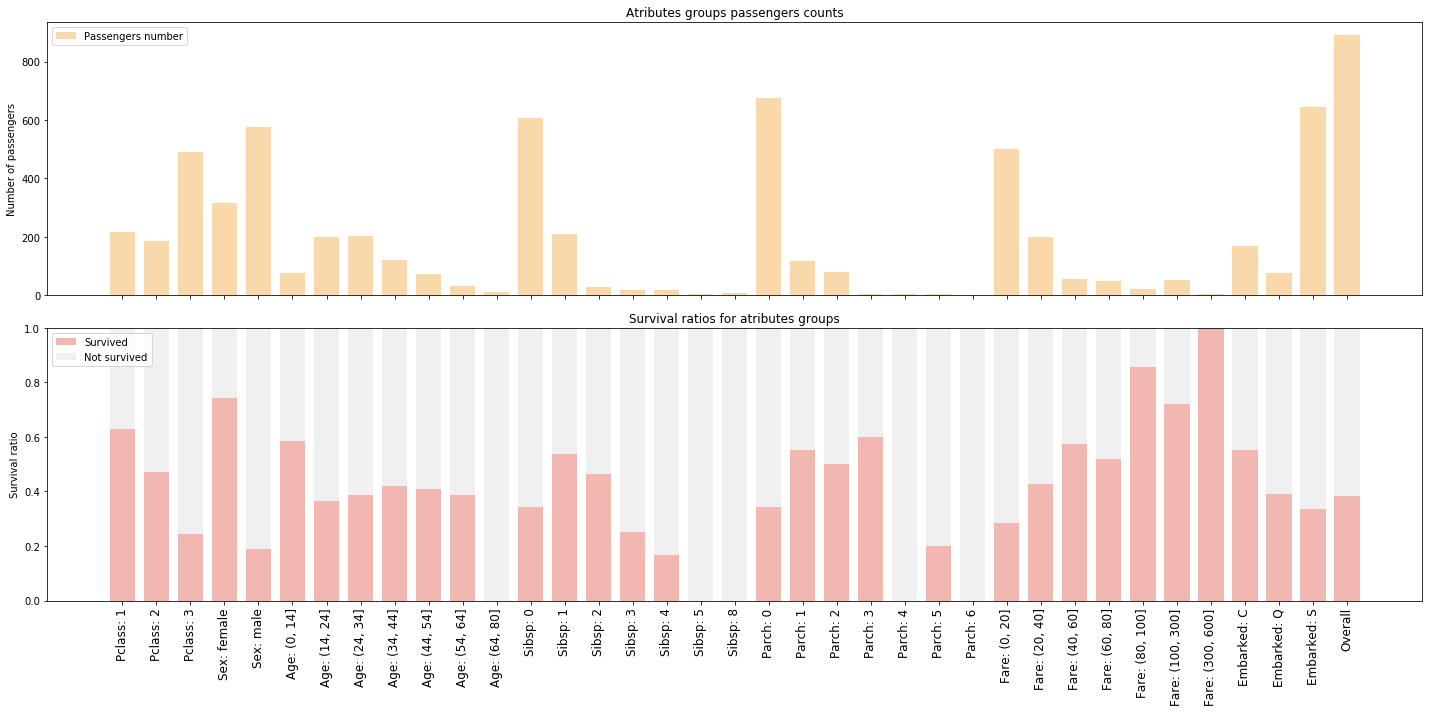

In [67]:
get_groups_survival_ratio_plot(survival_ratios.values, groups_counts.values, survival_ratios.index)

Let's now finally analyse the survival ratio for different attributes subgroups. As a reference on the right hand side of the graph we placed the overal Titanic passengers survival ratio - it is equal to 0.38. To test whether attribute's values affected the passengers survival ratio significantly (in inferential statistics meaning) we will use .05 significance level.

### 3.5.1 Pclass attribute

Let's start with `Pclass` survival ratio levels. As we could expect, based on popular knowledge, the first (and even second) class passengers had a lot greater chances of survival than third class passengers. The survival ratio was 0.63 in the first class meaning that 63% of passengers travelling in this class survived. Second class had a bit lower survival ratio of 0.47. But the third class passengers survival ratio of 0.24 is shocking. Only 24% of third class passengers survived the disaster. That plus the fact that third class was the most populated (third bar in the top plot) with 491 passengers (out of all 891 in this dataset) gives the image of dramatic situation these people were in. Looking for the reasons of this high mortality level is beyond the scope of this analysis.


In [68]:
model = ols("Survived ~ C(Pclass)", titanic_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Survived   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     57.37
Date:                Sun, 14 Jan 2018   Prob (F-statistic):           3.72e-24
Time:                        01:57:08   Log-Likelihood:                -566.83
No. Observations:                 890   AIC:                             1140.
Df Residuals:                     887   BIC:                             1154.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.6279      0.031     20.092      0.000       0.567       0.689
C(Pclass)[T.2]    -0.1551      0.046     -3.370      0.001      -0.245      -0.065
C(Pclass)[T.3]    -0.3855      0.037    -10.288      0.000      -0.459      -0.312
==============================================================================
Omnibus:                     1398.566   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.283
Skew:                           0.424   Prob(JB):                     1.11e-19
Kurtosis:                       1.721   Cond. No.                         4.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All three passengers classes effects are significant with p < .05. 

### 3.5.2 Sex attribute

Looking at `Sex` attribute groups values we also see clear relationship in terms of survival ratio. Clearly women were more likely to survive than men with 0.74 survival ratio for women and 0.18 for men. Again this is what we could expect from popular knowledge. This could be expected following "Women and children first" marine code of conduct (more about it [here](https://en.wikipedia.org/wiki/Women_and_children_first)). This fact is clearly visible in the data.

In [69]:
model = ols("Survived ~ C(Sex)", titanic_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Survived   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     375.3
Date:                Sun, 14 Jan 2018   Prob (F-statistic):           5.17e-70
Time:                        01:57:08   Log-Likelihood:                -464.09
No. Observations:                 890   AIC:                             932.2
Df Residuals:                     888   BIC:                             941.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.7420      0.023     32.224      0.000       0.697       0.787
C(Sex)[T.male]    -0.5545      0.029    -19.373      0.000      -0.611      -0.498
==============================================================================
Omnibus:                       25.375   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.091
Skew:                           0.427   Prob(JB):                     1.31e-06
Kurtosis:                       2.982   Cond. No.                         3.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Both sexes effects are significant with p < .05. 

### 3.5.3 Age attribute

Going step forward, was the same rescue law applied to children or maybe other age groups? Analysing `Age` attribute survival ratios it appears that the answer is positive. Passengers in the age group of 0-14 have much higher survival ratio of 0.58 than the rest of passengers. Other passengers age groups oscilate around the overall survival ratio of 0.38. With one exception however: for age group of 64-80 passengers have very small survival ratio of 0.09. Again this analysis is not a place to look for specific reasons for this fact.

In [70]:
model = ols("Survived ~ AgeGroup", titanic_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Survived   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     3.194
Date:                Sun, 14 Jan 2018   Prob (F-statistic):            0.00423
Time:                        01:57:08   Log-Likelihood:                -494.93
No. Observations:                 713   AIC:                             1004.
Df Residuals:                     706   BIC:                             1036.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.5844      0.055     10.534      0.000       0.475       0.693
AgeGroup[T.(14, 24]]    -0.2194      0.065     -3.361      0.001      -0.348      -0.091
AgeGroup[T.(24, 34]]    -0.1964      0.065     -3.010      0.003      -0.324      -0.068
AgeGroup[T.(34, 44]]    -0.1629      0.071     -2.296      0.022      -0.302      -0.024
AgeGroup[T.(44, 54]]    -0.1735      0.080     -2.181      0.030      -0.330      -0.017
AgeGroup[T.(54, 64]]    -0.1973      0.104     -1.906      0.057      -0.401       0.006
AgeGroup[T.(64, 80]]    -0.5844      0.164     -3.571      0.000      -0.906      -0.263
==============================================================================
Omnibus:                       15.115   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.001   Jarque-Bera (JB):              110.115
Skew:                           0.364   Prob(JB):                     1.23e-24
Kurtosis:                       1.218   Cond. No.                         10.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All ages groups besides `(54, 64`] group effects are significant with p < .05. 

### 3.5.4 Sibsp attribute

Let's now analyze `Sibsp` and groups of passengers travelling with different number of siblings or spouse. The data set specification defines siblings as: brother, sister, stepbrother, stepsister. It also defines spouse as: husband, wife. There is no other information in the data set that could help us to separate these two groups (whether passenger traveled with sibling, spouse or alone) so we will analyse as is in the data set.

It is interesting whether travelling with siblings or spouse affected chances for survival. 608 passengers, meaning vast majority, traveled without any with 0.35 survival ratio. Passengers travelling with one and two siblings or spouse had higher survival chances of 0.54 and 0.46. There were passengers travelling with three, four, five and eight siblings or spouse on board. Their survival ratio was lower and reaching 0 for the last two groups. Again analysing these groups we need to remeber that very few passengers belonged to these groups. For example, only 7 passengers belonged to 8 siblings or spouse group. Let's see who they were.

In [71]:
titanic_train[titanic_train["SibSp"] == 8]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup,FareGroup
PassengerId,,,,,,,,,,,,,
160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,"(60, 80]"
181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,"(60, 80]"
202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,"(60, 80]"
325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,"(60, 80]"
793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,"(60, 80]"
847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,"(60, 80]"
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,"(60, 80]"


As we can see it is a case of a tragic story of one big familly, all travelling in the third class. Unfortunatelly all died in the disaster. In fact it was two parents travelling with 8 children but three of them are not included in this dataset. That is why `SibSp` is 8 even though we have only 7 individuals here. You can read more about their story [here](https://www.encyclopedia-titanica.org/titanic-victim/thomas-henry-sage.html).

In [72]:
model = ols("Survived ~ C(SibSp)", titanic_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Survived   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     6.475
Date:                Sun, 14 Jan 2018   Prob (F-statistic):           1.07e-06
Time:                        01:57:08   Log-Likelihood:                -601.80
No. Observations:                 890   AIC:                             1218.
Df Residuals:                     883   BIC:                             1251.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.3443      0.019     17.759      0.000       0.306       0.382
C(SibSp)[T.1]     0.1916      0.038      5.000      0.000       0.116       0.267
C(SibSp)[T.2]     0.1200      0.092      1.299      0.194      -0.061       0.301
C(SibSp)[T.3]    -0.0943      0.121     -0.780      0.436      -0.332       0.143
C(SibSp)[T.4]    -0.1776      0.114     -1.555      0.120      -0.402       0.047
C(SibSp)[T.5]    -0.3443      0.215     -1.605      0.109      -0.765       0.077
C(SibSp)[T.8]    -0.3443      0.182     -1.896      0.058      -0.701       0.012
==============================================================================
Omnibus:                       27.286   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.234
Skew:                           0.444   Prob(JB):                     8.65e-29
Kurtosis:                       1.358   Cond. No.                         13.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Only passengers travelling without any and with one sibling/spouse effects are significant with p < .05. 

### 3.5.5 Parch attribute

Moving on to analysis of `Parch` attribute survival ratio. Again vast majority of passengers (678) traveled without any children or parents with survival ratio of 0.34. We can see that passengers travelling with one, two or three children or parents had bigger chances of survival (0.55, 0.50 and 0.60 accordingly), but again let's remember that these groups had much less passengers (118, 80, 5). There were only 10 passenger travelling with four, five or six parents or children and their survival ratio was small but these groups are to small to draw any conclusions.


In [73]:
model = ols("Survived ~ C(Parch)", titanic_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Survived   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     4.809
Date:                Sun, 14 Jan 2018   Prob (F-statistic):           7.71e-05
Time:                        01:57:08   Log-Likelihood:                -606.65
No. Observations:                 890   AIC:                             1227.
Df Residuals:                     883   BIC:                             1261.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.3427      0.018     18.565      0.000       0.306       0.379
C(Parch)[T.1]     0.2082      0.048      4.345      0.000       0.114       0.302
C(Parch)[T.2]     0.1573      0.057      2.770      0.006       0.046       0.269
C(Parch)[T.3]     0.2573      0.216      1.194      0.233      -0.166       0.680
C(Parch)[T.4]    -0.3427      0.241     -1.423      0.155      -0.815       0.130
C(Parch)[T.5]    -0.1427      0.216     -0.662      0.508      -0.566       0.280
C(Parch)[T.6]    -0.3427      0.481     -0.713      0.476      -1.286       0.601
==============================================================================
Omnibus:                       29.577   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.501
Skew:                           0.464   Prob(JB):                     1.02e-29
Kurtosis:                       1.345   Cond. No.                         30.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Only passengers travelling without any and with one or two children/parents effects are significant with p < .05. 

### 3.5.6 Fare attribute

When we look at `Fare` attribute survival ratio values we can see clearly almost linear relation between the price of the ticket and the survival ratio. It looks like the more passenger paid for the ticket the bigger were the chances of survival. The survival ratio for passengers who bought the tickets for 0-20 was 0.28, for passengers with tickers between 20-40 the survival ratio was 0.43. And for further groups: 40-60 0.57, 60-80 0.520833, 80-100 0.86, 100-300, 0.72, and for tickets with price between 300-600 the survival ratio was 1.00 meaning that all of these passengers survived. There are two facts we need to mention. First, the more expesive ticket the higher class in which passenger traveled meaning of course the higher chances for survival. Second, the number of passengers in groups of ticket prices above 40 is about 50 passengers making them small with only three passengers in the most expensive 300-600 ticket price range price group.


In [74]:
model = ols("Survived ~ C(FareGroup)", titanic_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Survived   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     15.91
Date:                Sun, 14 Jan 2018   Prob (F-statistic):           2.00e-17
Time:                        01:57:08   Log-Likelihood:                -575.27
No. Observations:                 890   AIC:                             1165.
Df Residuals:                     883   BIC:                             1198.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.2777      0.020     13.591      0.000       0.238       0.318
C(FareGroup)[T.(100, 300]]     0.4423      0.069      6.440      0.000       0.308       0.577
C(FareGroup)[T.(20, 40]]       0.1495      0.039      3.862      0.000       0.074       0.225
C(FareGroup)[T.(300, 600]]     0.7223      0.268      2.691      0.007       0.195       1.249
C(FareGroup)[T.(40, 60]]       0.2964      0.066      4.469      0.000       0.166       0.427
C(FareGroup)[T.(60, 80]]       0.2432      0.070      3.475      0.001       0.106       0.380
C(FareGroup)[T.(80, 100]]      0.5795      0.103      5.614      0.000       0.377       0.782
==============================================================================
Omnibus:                    17099.237   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.885
Skew:                           0.505   Prob(JB):                     6.17e-24
Kurtosis:                       1.636   Cond. No.                         17.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

However all passengers tickets fares groups effects are significant with p < .05. 

### 3.5.7 Embarked attribute

Finally let's look at the `Embarked` atribute passengers groups. As a reminder: `C` stands for Cherbourg port of departure, `Q` stands for Queenstown and `S` stands for Southampton. Majority of Titanic passengers (644) embarked in Southhampton. Also this group of passengers have the lowest survival ratio out of all three ports of embarkation (0.34). Similarly passengers who embarked in Queenstown had survival ratio equal to 0.39. However those who embarked in Cherbourg had survival ratio of 0.55. First of all there were much less passengers embarking in the last two ports: only 77 passengers in Queenstown and 168 passengers in Cherbourg. We could guess, considering large number of passengers, that the third class passengers embarked mostly in Southhampton and Queenstown and that could be the reason for such small, as compared to Cherbourg port, survival ratio for passengers embarking here. Let's check it with data.

In [75]:
titanic_embarked_group.get_group("S")["Pclass"].value_counts(sort=False)

1    126
2    164
3    353
Name: Pclass, dtype: int64

In [76]:
titanic_embarked_group.get_group("Q")["Pclass"].value_counts(sort=False)

1     2
2     3
3    72
Name: Pclass, dtype: int64

In [77]:
titanic_embarked_group.get_group("C")["Pclass"].value_counts(sort=False)

1    85
2    17
3    66
Name: Pclass, dtype: int64

That confirms our hypothesis: both in Southampton and Queenstown third class passengers were the majority of embarking there. In Cherbourg port the situation was the opposite: first class passengers were the majority and that is the reason survival ratio is so high for that passengers subgroup.

In [78]:
model = ols("Survived ~ Embarked", titanic_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Survived   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     13.75
Date:                Sun, 14 Jan 2018   Prob (F-statistic):           1.32e-06
Time:                        01:57:08   Log-Likelihood:                -605.37
No. Observations:                 888   AIC:                             1217.
Df Residuals:                     885   BIC:                             1231.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5536      0.037     14.971      0.000       0.481       0.626
Embarked[T.Q]    -0.1640      0.066     -2.486      0.013      -0.293      -0.035
Embarked[T.S]    -0.2176      0.042     -5.241      0.000      -0.299      -0.136
==============================================================================
Omnibus:                       31.328   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.204
Skew:                           0.480   Prob(JB):                     1.19e-29
Kurtosis:                       1.363   Cond. No.                         5.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All passengers embarkation ports effects are significant with p < .05. 

## 4. Modelling data preparation <a class="anchor" id="preparation"></a>

We will start by loading fresh data set without any modifications.

In [79]:
titanic_train = pd.read_csv("datasets/train.csv")
titanic_train = titanic_train.set_index("PassengerId")
titanic_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's now separate the predictors and the labels since we don’t necessarily want to apply the same transformations to them.

In [80]:
titanic_train_predict = titanic_train.drop("Survived", axis=1)
titanic_train_labels = titanic_train["Survived"]

In [81]:
titanic_train_predict.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [82]:
titanic_train_labels.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

In the data exploration phase we decided that we will not use `Name`, `Ticket` and `Cabin` attributes since they convey no patterns for our model to use. Let's drop these attributes from our train data set then.

In [83]:
titanic_train_predict = titanic_train_predict.drop(["Name", "Ticket", "Cabin"], axis=1)

In [84]:
titanic_train_predict.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,male,22.0,1,0,7.2500,S
2,1,female,38.0,1,0,71.2833,C
3,3,female,26.0,0,0,7.9250,S
4,1,female,35.0,1,0,53.1000,S
5,3,male,35.0,0,0,8.0500,S


We are left with seven predictor attributes in the dataset. There are four problems we need to deal with: missing values, quite large numerical values scale differences, numerical categorical attributes and textual categorical attributes which are not to convenient for machine learning algorithms. 

Let's start by taking care of missing values in the data. 

In [85]:
titanic_train_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 7 columns):
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 55.7+ KB


We can see that `Age` and `Embarked` attributes have some missing values. And when the latter misses values only in two training examples, the former has 177 missing values. There are three strategies we can take: get rid of whole attribute, get rid of missing data examples or fill the missing data with media or mean value for example. 

When it comes to `Embarked` we can fill these two cases with distribution mode value - that is Southampton. When it comes to `Age` - we cannot drop 177 training example. We also cannot drop whole `Age` attribute since it seems crucial survival indicator. What we are left with is to fill the missing values. And since `Age` distribution is skewed (positively) we will fill it with median value since it is a better central tendency measure for such distributions. 

As for quite large numerical values scale differences, we will take care of this by applying feature scaling to our numerical attributes values.

In [86]:
titanic_train_predict.describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


As for categorical numerical values, `Pclass`, `SibSp` and `Parch`, integer attribute representation cannot be used directly with scikit-learn estimators, as these expect continuous input, and would interpret the categories as being ordered, which is not desired. To convert categorical features to features that can be used with scikit-learn estimators we will use a one-hot encoding, which is implemented in OneHotEncoder. This estimator transforms each categorical feature with m possible values into m binary features, with only one active.

And as for categorical textual attributes: `Sex` and `Embarked`. These textual categorical values first need to be coded as integers and then they will also encoded using OneHotEncoder.

Let's now separate numerical continous, numerical categorical and textual attributes for further processing.

In [87]:
titanic_train_predict_num = titanic_train_predict[["Age", "Fare"]]
titanic_train_predict_cat = titanic_train_predict[["Pclass", "SibSp", "Parch"]]
titanic_train_predict_txt = titanic_train_predict[["Sex", "Embarked"]]

In [88]:
titanic_train_predict_num.head()

,Age,Fare
PassengerId,,
1,22.0,7.2500
2,38.0,71.2833
3,26.0,7.9250
4,35.0,53.1000
5,35.0,8.0500


In [89]:
titanic_train_predict_cat.head()

,Pclass,SibSp,Parch
PassengerId,,,
1,3,1,0
2,1,1,0
3,3,0,0
4,1,1,0
5,3,0,0


In [90]:
titanic_train_predict_txt.head()

,Sex,Embarked
PassengerId,,
1,male,S
2,female,C
3,female,S
4,female,S
5,male,S


To perform all numerical attributes transformations - missing data imputation and features scaling - we will use Pipeline.

In [91]:
num_pipeline = Pipeline([
    ("imputer", Imputer(strategy="median")),
    ("std_scaler", StandardScaler()),
])

titanic_train_predict_num_tr = num_pipeline.fit_transform(titanic_train_predict_num)
titanic_train_predict_num_tr

array([[-0.56573646, -0.50244517],
       [ 0.66386103,  0.78684529],
       [-0.25833709, -0.48885426],
       ..., 
       [-0.1046374 , -0.17626324],
       [-0.25833709, -0.04438104],
       [ 0.20276197, -0.49237783]])

In [92]:
titanic_train_predict_num_tr.shape

(891, 2)

Missing values were filled with median value and attributes were scaled properly.

As mentioned to transform categorical numerical attributes we will use OneHotEncoder.

In [93]:
encoder = OneHotEncoder(n_values=[4, 9, 10])
titanic_train_predict_cat_1hot = encoder.fit_transform(titanic_train_predict_cat).toarray()

We have four (couting with 0 values as a empty base class) possible categories in `Pclass`, nine possible categories in `SibSp` and ten possible categories in `Parch` attribute. That makes 23 values for each encoded training examples. Let's check it.

In [94]:
titanic_train_predict_cat_1hot.shape

(891, 23)

And that is correct.

As the last part we will take care of textual categorical values. As mentioned we will first encode values with intergers. We can use Pandas' `factorize()` method to convert this string categorical features to an integer categorical features. Then we will again use OneHotEncoder.

However first we need to fill the missing values.

In [95]:
titanic_train_predict_txt["Embarked"] = titanic_train_predict_txt["Embarked"].fillna("S")

In [96]:
titanic_train_predict_txt_cat = titanic_train_predict_txt.apply(lambda x: pd.factorize(x)[0])

In [97]:
encoder = OneHotEncoder(n_values=[2, 3])
titanic_train_predict_txt_1hot = encoder.fit_transform(titanic_train_predict_txt_cat).toarray()
titanic_train_predict_txt_1hot

array([[ 1.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  1.,  0.],
       [ 0.,  1.,  1.,  0.,  0.],
       ..., 
       [ 0.,  1.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  1.]])

Again we should have two categories from `Sex` attribute and three from `Embarked` making five in total for encoded values.

In [98]:
titanic_train_predict_txt_1hot.shape

(891, 5)

The data looks correct.

We now have three arrays of data ready to be processed by machine learning algos. Let's concatenate them into one array.

In [99]:
titanic_train_predict = np.concatenate([titanic_train_predict_num_tr, titanic_train_predict_cat_1hot, titanic_train_predict_txt_1hot], axis=1)

In [100]:
titanic_train_predict.shape

(891, 30)

We have 30 features for our 891 training examples with all missing values filled in.

Let's now streamline this whole process to a function for future smooth predictors data preprocessing (e.g. preprocessing test dataset).

In [9]:
def preprocess_predict_dataset(titanic_predict):
     
    # Remove unnecessary attributes. 
    titanic_predict = titanic_predict.drop(["Name", "Ticket", "Cabin"], axis=1)

    # Split data depending on the attribute type and processing needed.
    titanic_predict_num = titanic_predict[["Age", "Fare"]]
    titanic_predict_cat = titanic_predict[["Pclass", "SibSp", "Parch"]]
    titanic_predict_txt = titanic_predict[["Sex", "Embarked"]]

    # Process numerical attributes.
    num_pipeline = Pipeline([
        ("imputer", Imputer(strategy="median")),
        ("std_scaler", StandardScaler()),
    ])
    titanic_predict_num_tr = num_pipeline.fit_transform(titanic_predict_num)

    # Process numerical categorical attributes.
    encoder = OneHotEncoder(n_values=[4, 9, 10])
    titanic_predict_cat_1hot = encoder.fit_transform(titanic_predict_cat).toarray()

    # Process textual categorical attributes.
    titanic_predict_txt["Embarked"] = titanic_predict_txt["Embarked"].fillna("S")
    titanic_predict_txt_cat = titanic_predict_txt.apply(lambda x: pd.factorize(x)[0])
    
    encoder = OneHotEncoder(n_values=[2, 3])
    titanic_predict_txt_1hot = encoder.fit_transform(titanic_predict_txt_cat).toarray()

    # Prepare the final dataset.
    titanic_predict = np.concatenate([titanic_predict_num_tr, 
                                      titanic_predict_cat_1hot, 
                                      titanic_predict_txt_1hot], axis=1)
    
    return titanic_predict

Let's test the whole data preprocessing flow.

In [10]:
titanic_train = pd.read_csv("datasets/train.csv")
titanic_train = titanic_train.set_index("PassengerId")

titanic_train_predict = titanic_train.drop("Survived", axis=1)
titanic_train_labels = titanic_train["Survived"]

titanic_train_predict = preprocess_predict_dataset(titanic_train_predict)

In [11]:
titanic_train_predict.shape, titanic_train_labels.shape

((891, 30), (891,))

Datasets look good. We can move on to machine learning models prototyping.

## 5. Models prototyping <a class="anchor" id="prototyping"></a>

Our data is prepared so we are ready to train multiple quick models to check how they behave. As we stated in the begining of this analysis we deal with supervised learning binary clasification problem so we will try multiple classification algorithms. Our measure is classification accuracy. We will evaluate our models using cross-validation on training dataset. This way the training set remains full and the assessment will be much more accurate as compared to using training data to train and measure the results in which case we risk traning data overfitting.

Let's start with logistic regression.

In [104]:
log_clf = LogisticRegression()
log_clf.fit(titanic_train_predict, titanic_train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [105]:
cross_val_score(log_clf, titanic_train_predict, titanic_train_labels, 
                cv=3, scoring="accuracy")

array([ 0.7979798,  0.8047138,  0.8047138])

That looks like a promising result.

Let's try now Stochastic Gradient Descent classifier.

In [106]:
sgd_clf = SGDClassifier()
sgd_clf.fit(titanic_train_predict, titanic_train_labels)
cross_val_score(sgd_clf, titanic_train_predict, titanic_train_labels, 
                cv=3, scoring="accuracy")

array([ 0.7003367 ,  0.77777778,  0.74747475])

A bit worse than Logistic Regression.

Another algorithm we will prototype is k-nearest neighbors algorithm.

In [130]:
knn_clf = KNeighborsClassifier(n_neighbors = 3)
knn_clf.fit(titanic_train_predict, titanic_train_labels)
cross_val_score(knn_clf, titanic_train_predict, titanic_train_labels, 
                cv=3, scoring="accuracy")

array([ 0.76767677,  0.78114478,  0.7979798 ])

Better results than Stochastic Gradient Descent but still not a top result.

Next we will try Gausian Naive Bayes algorithm.

In [108]:
bayes_clf = GaussianNB()
bayes_clf.fit(titanic_train_predict, titanic_train_labels)
cross_val_score(bayes_clf, titanic_train_predict, titanic_train_labels, 
                cv=3, scoring="accuracy")

array([ 0.42087542,  0.4040404 ,  0.3973064 ])

Definetely the worst result so far.

Let's see how Linear Suppor Vector Machine will perform.

In [7]:
lin_svc_clf = LinearSVC(loss="hinge")
lin_svc_clf.fit(titanic_train_predict, titanic_train_labels)
cross_val_score(lin_svc_clf, titanic_train_predict, titanic_train_labels,
                cv=3, scoring="accuracy")

array([ 0.78787879,  0.81481481,  0.78114478])

That is really promising result but not the best.

Let's now check other linear SVC classifier offered by scikit. The difference between them is the underlying C implementation: LinearSVC uses liblinear library and the solver for SVC is libsvm.

In [131]:
svc_clf = SVC(kernel="linear")
svc_clf.fit(titanic_train_predict, titanic_train_labels)
cross_val_score(svc_clf, titanic_train_predict, titanic_train_labels,
                cv=3, scoring="accuracy")

array([ 0.79124579,  0.81481481,  0.78451178])

That is surprising how better results we get - this is one of the top results so far.

And now non-linear SVC kernel using Gaussian Radial Basis Function.

In [111]:
rbf_svc_clf = SVC(kernel="rbf")
rbf_svc_clf.fit(titanic_train_predict, titanic_train_labels)
cross_val_score(rbf_svc_clf, titanic_train_predict, titanic_train_labels,
                cv=3, scoring="accuracy")

array([ 0.78451178,  0.7979798 ,  0.77777778])

This SVC kernel give medium results - not the worst but also not the best.

Let's now test Decision Tree algorithm.

In [112]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(titanic_train_predict, titanic_train_labels)
cross_val_score(tree_clf, titanic_train_predict, titanic_train_labels,
                cv=3, scoring="accuracy")

array([ 0.73737374,  0.76430976,  0.76767677])

That's good result - looks promising.

And now enseble method Random Forrests algorithm.

In [132]:
forest_clf = RandomForestClassifier()
forest_clf.fit(titanic_train_predict, titanic_train_labels)
cross_val_score(forest_clf, titanic_train_predict, titanic_train_labels,
                cv=3, scoring="accuracy")

array([ 0.76767677,  0.81818182,  0.79124579])

Again this is a satisfying accuracy score.

To sum up we have following algorithms cross-validation best results for the following algorithms:
```
Logistic Regression 			    0.7979798,  0.8047138,  0.8047138
SVC with linear kernel 			 0.79124579, 0.81481481, 0.78451178
Random Forrest 				     0.76767677, 0.81818182, 0.79124579
```
We will try to fine-tune these models to improve them even more and then select the best one to be deployed and used with our test dataset.

## 6. Models hyperparameters fine-tuning <a class="anchor" id="tuning"></a>

We will now perform our best prototype models hyperparameter fine-tuning. So far we used them with default parameters only. Tuning each manually, considering number of possible params and values to test, would be to difficult. That is why we will use grid-search to search for models best parameters.

We will start with Logistic Regression tuning. We will perform grid search on ridge vs. lasso regularization methods, different regularization strengths and number of iterations.

In [114]:
log_param_grid = [{
    "penalty": ["l1", "l2"], 
     'C': [0.001, 0.01, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000], 
     "max_iter": [100, 200, 300]
}]

log_clf = LogisticRegression()
log_grid_search = GridSearchCV(log_clf, log_param_grid, cv=5, scoring="accuracy")
log_grid_search.fit(titanic_train_predict, titanic_train_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000], 'max_iter': [100, 200, 300]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

Let's have a look at best accuracy score and model parameter we get it for.

In [115]:
log_grid_search.best_score_

0.80920314253647585

In [116]:
log_grid_search.best_params_

{'C': 3, 'max_iter': 100, 'penalty': 'l2'}

0.809 is better result than before.

Let's move on SVM tuning. This time we will perform grid search on different regularization strengths.

In [117]:
svm_param_grid = [{"C": [0.3, 1, 3]}]

svc_clf = SVC(kernel="linear")
svc_grid_search = GridSearchCV(svc_clf, svm_param_grid, cv=3, scoring="accuracy")
svc_grid_search.fit(titanic_train_predict, titanic_train_labels)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1, param_grid=[{'C': [0.3, 1, 3]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

Again let's see our accuracy measure result for tuned model and its parameters.

In [118]:
svc_grid_search.best_score_

0.79685746352413023

In [119]:
svc_grid_search.best_params_

{'C': 1}

We did not manage to tune SVC linear kernel model to be much better than in prototyping phase.

And finally let's fine-tune our Random Forest classfier. We will tune it with different combinations of number of estimators and maximal number of features parameters.

In [120]:
forest_param_grid = [
    {"n_estimators": [3, 10, 30, 50, 60, 70, 80, 90, 120, 180, 270, 360, 500], 
     "max_features": [2, 4, 6, 8, 10, 12, 20, 22]},
]

forest_clf = RandomForestClassifier()
forest_grid_search = GridSearchCV(forest_clf, forest_param_grid, cv=5, scoring="accuracy")
forest_grid_search.fit(titanic_train_predict, titanic_train_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30, 50, 60, 70, 80, 90, 120, 180, 270, 360, 500], 'max_features': [2, 4, 6, 8, 10, 12, 20, 22]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

Let's see result of this algorithm fine-tuning.

In [121]:
forest_grid_search.best_score_

0.8271604938271605

In [122]:
forest_grid_search.best_params_

{'max_features': 22, 'n_estimators': 10}

This is clearly our best model classification accuracy result. We will use it as our final model.

## 7. Model test dataset evaluation and deployment <a class="anchor" id="evaluation"></a>

Let's now use test dataset to evaluate our best model. This time when loading data we do not have to separate the predictors and the labels. The dataset contains only predictors. It is prepared for Kaggle submission. We get test dataset evaluation score after submitting it to the competition where our model predictions are compared with test dataset labels (unknown to us).

In [123]:
titanic_test_predict = pd.read_csv("datasets/test.csv")
titanic_test_predict = titanic_test_predict.set_index("PassengerId")

titanic_test_predict = preprocess_predict_dataset(titanic_test_predict)

In [124]:
titanic_test_predict.shape

(418, 30)

The test data is ready. Let's evaluate our final model on the test set: fine-tuned Random forest proved to be the best of several tested modelling methods. Let's copy the tuned model and use it to make predictions based on our preprocessed test dataset.

In [125]:
final_model = forest_grid_search.best_estimator_

In [126]:
final_prediction = final_model.predict(titanic_test_predict)

Our final model prediction is ready. Let's now write it to submission data file prepared along the specifications we set in the beginning of this analysis.

In [127]:
final_prediction_df = pd.DataFrame({'PassengerId': range(892, 892+len(final_prediction)), 
                                    'Survived': final_prediction})

In [128]:
final_prediction_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [129]:
final_prediction_df.to_csv("datasets/submission.csv", index=False)

After submission we achieved 0.74162 accuracy in test dataset validation. Not bad but we still can improve our models quite a lot. To be continued.

## 8. Summary <a class="anchor" id="summary"></a>

In this analysis we worked with Titanic survival dataset for 891 passengers data out of all 2224 Titanic passengers.

We first answered what was Titanic passengers demographic structure analyzed in terms of attributes. We saw that vast majority (55.11%) of passengers travelled in lowest third class, almost 25% of passengers travelled in first class and 20.65% traveled in second class. Majority of all passengers were males: 64.76% and only 35.24% of females. 10.78% of passengers were children in age of 0-14. A little over 28% of passengers were both between 14-24 and 24-34 years old. Almost 17% of all passengers were 34-44 years old. Only 16% of all passengers were above 44 years old. That tells us that Titanic passengers population was quite young.

Vast majority of passengers travelled without any siblings or spouse - 68.24% of them. 23.46% of passengers travelled with one child or spouse. Less than 9% of all passengers traveled with more than one sibling or spouse. The situation is very similar in case of passengers travelling with parents or children. Most of them, 76.09%, travelled alone and 13.24% travelled with just one parent or children. 8.89% of passengers travelled with two parents or children. In terms of ticket fare over the half, 57.08%, of passengers paid the lowest fare ranging from 0 to 20. 22.83% passengers paid between 20 and 40 fare. We saw that the rest of the ticket prices, 20.11%, varies very much ranging from 40 to 600. Finally we can see that vast majority of passengers, 72.44%, embarked in Southampton, 18.9% embarked in Cherbourg and only 8.66% of passengers embarked Titanic in Queenstown.

In this part of analysis by accident we found error in the Titanic dataset. We found out that the age of the person appearing in the dataset as the oldest (80) is the age of actual death many years after person disaster survival. This means that dataset age information for this passenger, by error, contains age value of the post Titanic death and not the day of disaster age as it does for other survived passengers age attribute. This inconsistency makes the data invalid and confusing when it comes to factual or historical value.

We answered what is the overall Titanic passengers survival ratio. We found out that from Titanic 891 passengers only 342 survived and 549 died. The Titanic survival ratio is approximately 0.3838, meaning that only 38.38% of all passengers survived the disaster.

Finally we turned to the analysis of survival ratio for different demographic passengers groups. As for passengers classes survival ratio, the survival ratio for the first class passengers was 0.63. Second class had a bit lower survival ratio of 0.47. But comparing that to the third class passengers survival ratio of 0.24 is shocking. All three passengers classes effects are significant with p < .05. Looking at gender based survival differences we also see clear relationship in terms of survival ratio values. Clearly women were more likely to survive than men with 0.74 survival ratio for women and 0.18 for men. Both gender effects are significant with p < .05. As for age groups survival ratio passengers in the age group of 0-14 have much higher survival ratio of 0.58 than the rest of passengers. Other passengers age groups oscillate around the overall survival ratio of 0.38. All ages groups effects besides (54, 64] group are significant with p < .05.

As for passengers travelling with different number of siblings or spouse, passengers travelling without any had survival ratio of 0.35. Passengers travelling with one and two sibling or spouse had higher survival chances of 0.54 and 0.46. Only passengers travelling without any and with one sibling/spouse effects are significant with p < .05. Considering groups of passengers depending on the number of parents and children they travelled with, again passengers travelling alone had survival ratio of 0.34. We can see that passengers travelling with one, two or three children or parents had bigger chances of survival, 0.55, 0.50 and 0.60 accordingly, but again let's remember that these groups had much less passengers. Only passengers travelling without any and with one or two children/parents effects are significant with p < .05.

When we look at ticket fare attribute survival ratio values we can see clearly almost linear relation between the price of the ticket and the survival ratio. It looks like the more passenger paid for the ticket the bigger were chances of survival. The survival ratio for passengers who bought the tickets for 0-20 was 0.28, for passengers with tickers between 20-40 the survival ratio was 0.43. And for further groups: 40-60 0.57, 60-80 0.520833, 80-100 0.86, 100-300 0.72. For tickets with price between 300-600 the survival ratio was 1.00 meaning that all of these passengers survived. All passengers tickets fares groups effects are significant with p < .05. Finally we looked at the Embarked attribute passengers groups. Passengers who embarked in Southampton had the lowest survival ratio out of all three ports of embarkation (0.34). Similarly passengers who embarked in Queenstown had survival ratio equal to 0.39. However those who embarked in Cherbourg had survival ratio of 0.55. We confirmed it with data that the third class passengers embarked mostly in Southampton and Queenstown and that could be the reason for such small, as compared to Cherbourg port, survival ratio for passengers embarking in Southampton. All passengers embarkation ports effects are significant with p < .05.

Finally we modeled our data using various machine learning algorithms. As a result of performed tests and hyperparameters tuning Random Forest model was proven to give best cross-validation accuracy score for survival predictions of 0.82716. After evaluating our final model on test dataset our model reached 0.74162 accuracy score. This is quite good result but also leaves quite a lot of space for improvements.